# Final Project
#### Antonio Alphonse

In [1]:
import os

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

import numpy as np
import sklearn.tree as tree
import sklearn.metrics as mt
import sklearn.ensemble as ens
import matplotlib.pyplot as plt

from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.model_selection import train_test_split

Here is a sample of the data obtained from challenger players, the highest skill group in League of Legends. The win column denotes whether Team0 or Team1 won that match. This data contains 625 entries, 25 recent matches (as of April 12, 2022) each from 20 random challenger players. The same method of obtaining data was used for the master and grandmaster ranks.

In [2]:
challengerData = pd.read_csv(os.path.join("Data","ChallengerMatchData.csv"))
gmData = pd.read_csv(os.path.join("Data","GrandmasterMatchData.csv"))
masterData = pd.read_csv(os.path.join("Data","MasterMatchData.csv"))

# Time is reported in seconds, converted to minutes.

challengerData["Game Duration"] = challengerData["Game Duration"] / 60
gmData["Game Duration"] = gmData["Game Duration"] / 60
masterData["Game Duration"] = masterData["Game Duration"] / 60

challengerData.head()

,Game Duration,Total Team Gold Earned,Total Team Crowd Control Time,Average Team Account Level,Average Team Champion Mastery,Total Team Kills,Total Team Vision Score,Win
0,32.266667,61656,103,166.8,13703.0,21,200,0
1,32.266667,64889,116,249.4,15151.8,33,235,1
2,28.966667,54559,107,322.0,11833.8,23,166,0
3,28.966667,65535,104,264.4,15157.4,41,147,1
4,29.050000,50667,123,446.4,11599.0,18,159,0


Game Duration was reported in seconds. The only pregame data obtained was account level and champion mastery. The alternating wins and losses in the preview of the data above is because each even entry is one team in a match and each odd entry is the opposing team of the same match. Here, I split the data into a training and testing set using an 60/20/20 split, with the win being the variable being measured. Division into a testing and training set was randomized.

Here I declare which data set to use.

In [42]:
data = gmData
pregame = data[["Average Team Account Level", "Average Team Champion Mastery", "Win"]]

# data = pregame
currentSet = "Grandmaster Pre Game"

# For other stuff:
datas = [challengerData, gmData, masterData]#[challengerData[["Average Team Account Level", "Average Team Champion Mastery", "Win"]], gmData[["Average Team Account Level", "Average Team Champion Mastery", "Win"]], masterData[["Average Team Account Level", "Average Team Champion Mastery", "Win"]]]
datasets = ["Challenger Post Game", "Grandmaster Post Game", "Master Post Game"]

models = []
Xs = []

partialDependences = []
aucs = []
precisionSets = []

data.head()

,Game Duration,Total Team Gold Earned,Total Team Crowd Control Time,Average Team Account Level,Average Team Champion Mastery,Total Team Kills,Total Team Vision Score,Win
0,27.266667,46831,57,451.8,11256.2,16,98,0
1,27.266667,59422,223,415.8,13783.0,32,137,1
2,18.533333,30453,43,438.8,7199.0,8,54,0
3,18.533333,40309,61,337.6,8975.8,24,81,1
4,29.450000,55022,70,504.0,13394.6,17,144,0


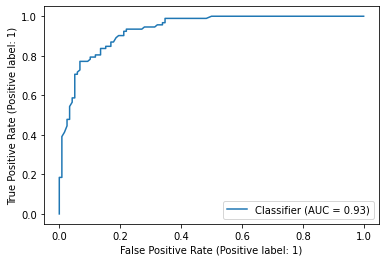

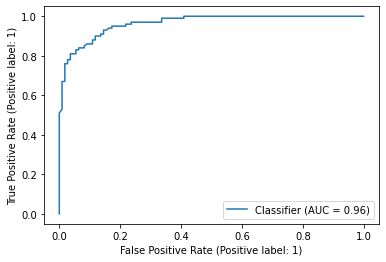

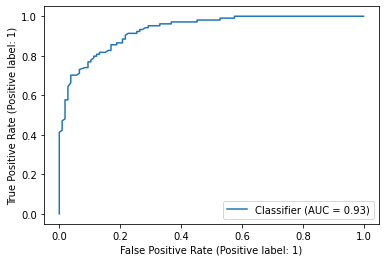

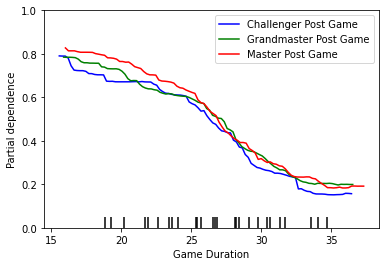

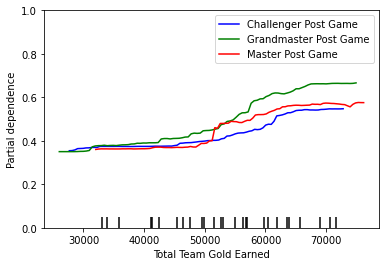

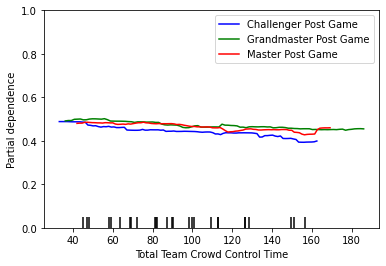

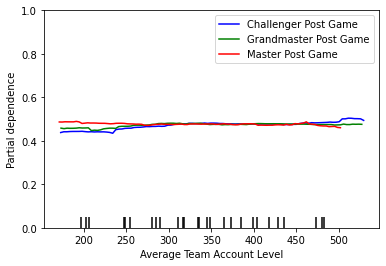

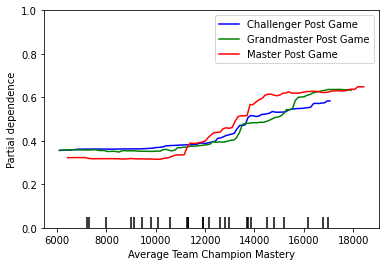

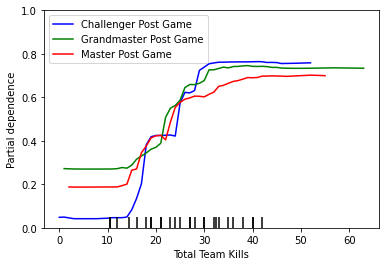

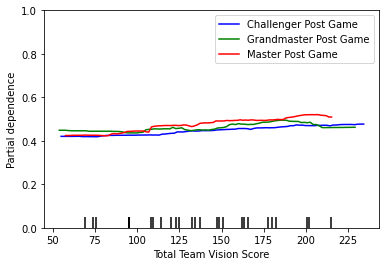

In [48]:
predictorRange = range(1, len(data.columns))

for i in range(0, 3):
    data = datas[i]
    featureSet = data.columns

    trainingX, testingX, trainingY, testingY = train_test_split(data[featureSet[:len(featureSet) - 1]], data["Win"], random_state=0, shuffle=True, test_size=0.2)

    # Split into validation set from training set
    trainingX, validX, trainingY, validY = train_test_split(trainingX, trainingY, random_state=0, shuffle=True, test_size=0.25)

    precisions = []

    for predictors in predictorRange:
        classifier = ens.RandomForestClassifier(n_estimators = 300, max_features=predictors)

        model = classifier.fit(trainingX, trainingY)

        validationPredict = model.predict(validX)

        precision = mt.precision_score(validY, validationPredict)

        precisions.append(precision)

    precisionSets.append(precisions)

    maxPredictors = predictorRange[precisions.index(max(precisions))]

    optimalRF = ens.RandomForestClassifier(n_estimators=300, max_features=maxPredictors)

    optimalModel = optimalRF.fit(trainingX, trainingY)

    optimalPredict = optimalModel.predict(testingX)
    classReport = mt.classification_report(testingY, optimalPredict)

    # Area under ROC Curve
    aucs.append(mt.RocCurveDisplay.from_predictions(testingY, optimalModel.predict_proba(testingX)[:,1]))

    models.append(optimalModel)
    Xs.append(testingX)

for feature in datas[0].columns[:len(datas[0].columns)-1]:
    challengerDisp = PartialDependenceDisplay.from_estimator(models[0], Xs[0], [feature], line_kw={"label":datasets[0], "color":"b"}, kind="average", target=1)
    gmDisp = PartialDependenceDisplay.from_estimator(models[1], Xs[1], [feature], ax=challengerDisp.axes_, line_kw={"label":datasets[1], "color":"g"}, kind="average", target=1)
    masterDisp = PartialDependenceDisplay.from_estimator(models[2], Xs[2], [feature], ax=challengerDisp.axes_, line_kw={"label":datasets[2], "color":"r"}, kind="average", target=1)

    plt.ylim(0,1)

# challengerAUC = aucs[0]
# gmAUC = aucs[1]
# masterAUC = aucs[2]

# print(challengerAUC)

# plt.plot(challengerAUC, "b", gmAUC, "g", masterAUC, "r")
# plt.show()


# print(partialDependences)

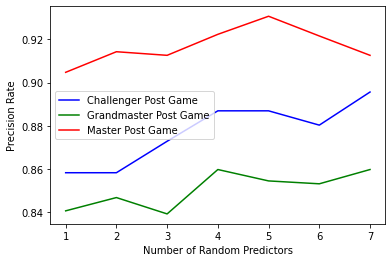

In [49]:
plt.plot(predictorRange, precisionSets[0], label=datasets[0], color="b")
plt.plot(predictorRange, precisionSets[1], label=datasets[1], color="g")
plt.plot(predictorRange, precisionSets[2], label=datasets[2], color="r")

plt.xlabel("Number of Random Predictors")
plt.ylabel("Precision Rate")
plt.legend()

In [46]:
featureSet = data.columns

trainingX, testingX, trainingY, testingY = train_test_split(data[featureSet[:len(featureSet) - 1]], data["Win"], random_state=0, shuffle=True, test_size=0.2)

# Split into validation set from training set
trainingX, validX, trainingY, validY = train_test_split(trainingX, trainingY, random_state=0, shuffle=True, test_size=0.25)

Here, I implement a Random Forest to establish a baseline. Later, I will refine this Random Forest to predict much better. To establish a baseline, I look at the precision of the testing set. I am using 100 trees to start. This number will change later as I look for where the errors stabilize. This procedure is done for attempting to classify games based on post-game data. 

Max Predictors: 1


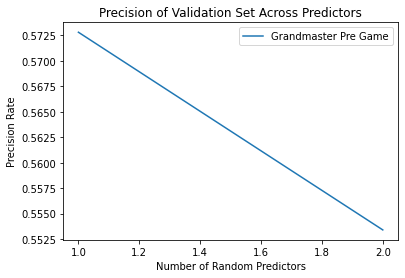

In [300]:
predictorRange = range(1, len(featureSet))
precisions = []

for predictors in predictorRange:
    classifier = ens.RandomForestClassifier(n_estimators = 300, max_features=predictors)

    model = classifier.fit(trainingX, trainingY)

    validationPredict = model.predict(validX)

    precision = mt.precision_score(validY, validationPredict)

    precisions.append(precision)

plt.title("Precision of Validation Set Across Predictors")

plt.plot(predictorRange, precisions, label=currentSet)

plt.xlabel("Number of Random Predictors")
plt.ylabel("Precision Rate")
plt.legend()

maxPredictors = predictorRange[precisions.index(max(precisions))]
print("Max Predictors: {}".format(maxPredictors))



Here I find the best number of trees to use with the number of random predictors that gives a maximum precision.

In [301]:
numTrees = range(50 , 301, 1)
precisions = []

for trees in numTrees:
    classifier = ens.RandomForestClassifier(n_estimators= trees, max_features=maxPredictors)
    treeModel = classifier.fit(trainingX, trainingY)

    treeValidationPredict = treeModel.predict(validX)

    precision = mt.precision_score(validY, treeValidationPredict)
    precisions.append(precision)

plt.figure(0)
plt.title("Precision of " + currentSet + " Validation Set Across Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("Precision Rate")
plt.plot(numTrees, precisions, label=currentSet)

maxTrees = numTrees[precisions.index(max(precisions))]
print("Number of Trees that Maximize Precision: {}".format(maxTrees))

It looks like the errors stabilize around 100 trees for the Master and Challenger skill divisions, but around 150 for the Grandmaster skill division. Now, I try to create a Random Forest where the errors seem to stabilize, along with max_features $\sqrt{p}$. NOTE: I use 300 Trees for all experiments.


Classification Report for Grandmaster Pre Game
              precision    recall  f1-score   support

           0       0.63      0.57      0.60       110
           1       0.57      0.63      0.60       100

    accuracy                           0.60       210
   macro avg       0.60      0.60      0.60       210
weighted avg       0.60      0.60      0.60       210

AUC Score for Grandmaster Pre Game: 0.6638181818181818


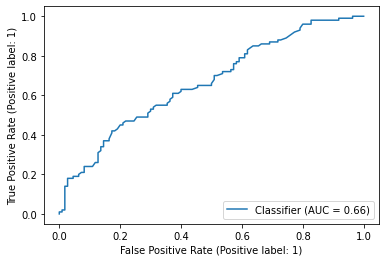

In [302]:
optimalRF = ens.RandomForestClassifier(n_estimators=300, max_features=maxPredictors)

optimalModel = optimalRF.fit(trainingX, trainingY)

optimalPredict = optimalModel.predict(testingX)
classReport = mt.classification_report(testingY, optimalPredict)
print("Classification Report for " + currentSet + "\n" + classReport)

# Area Under Curve score for Wins (We care about the model predicting wins accurately, not so much as losses)
aucScore = mt.roc_auc_score(testingY, optimalModel.predict_proba(testingX)[:,1])
print("AUC Score for " + currentSet + ": {}".format(aucScore))

# Area under ROC Curve
mt.RocCurveDisplay.from_predictions(testingY, optimalModel.predict_proba(testingX)[:,1])

# Column 0 is the losses, column 1 is the wins.
# print(optimalRandomForest.predict_proba(challengerTestingX))

It looks like for the Challenger data, the Random Forest algorithm has an 88 percent precision rate, but an 86 percent recall rate.
Next, I look for the important factors of the Random Forest.


Grandmaster Pre Game
                               Importance
Average Team Account Level      45.596778
Average Team Champion Mastery   54.403222


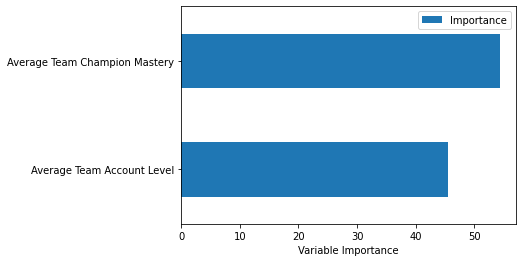

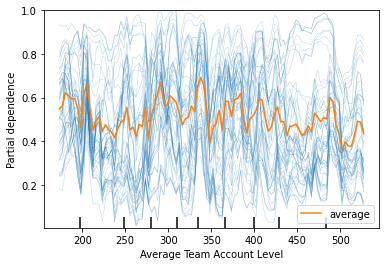

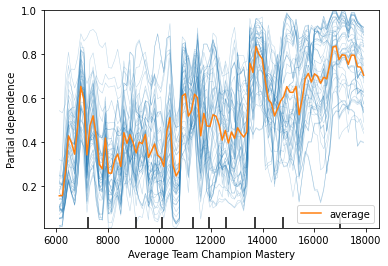

In [303]:
model = optimalModel
features = testingX.columns
X = testingX

print("\n"+currentSet)
importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=features)
print(importance.sort_values('Importance', axis=0, ascending=True))

# plt.pie(model.feature_importances_*100, labels=features)
importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh')
plt.xlabel('Variable Importance')

for i in range(0,len(features)):
    display = PartialDependenceDisplay.from_estimator(model, X, features[i:i+1], 
    target=0, subsample=50, kind="both", pd_line_kw={"color":"tab:orange"})

According to the data obtained, it seems like the total number of kills gained by a team had a high impact on determining whether a game was won or loss. Other important factors seem to be the game duration and the total amount of gold earned by the team, with the average team champion mastery having a near importance to the total team gold earned. It seems that team experience and skill has less of an impact than I thought. Map awareness and champion mobility also seems to play a smaller role in determining if a game was won. 

It's important to note that this information is pertaining to the Challenger skill group, and not the entirety of the game. It's also important to keep in mind that these are based on information that could only be gained in the post game. The two factors that would be consider pre-game information seem to have a small impact on the algorithm predicting a win or loss. 

Could there possibly be a better way of using pregame factors to predict?

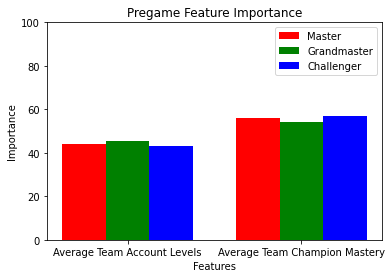

In [40]:
pregameImportances = [[45.596778, 54.403222, "Grandmaster"], [44.206631,55.793369,"Master"],[43.25667,56.74333,"Challenger"] ]
pregameCols = ["Average Team Account Levels", "Average Team Champion Mastery", "Rank"]

N = 2
ind = np.arange(N)
width=0.25

pregameImportance = pd.DataFrame(data=pregameImportances, columns=pregameCols)
pregameImportance[pregameImportance["Rank"] == "Master"]

plt.xlabel("Features")
plt.ylabel('Importance')
plt.title("Pregame Feature Importance")

bar1 = plt.bar(ind, [44.206631,55.793369], width, color="r")
bar2 = plt.bar(ind + width, [45.596778, 54.403222], width, color="g")
bar3 = plt.bar(ind + width + width, [43.25667,56.74333], width, color="b")

plt.xticks(ind+width,pregameCols[:2])
plt.ylim(top=100)
plt.legend((bar1, bar2, bar3), ("Master", "Grandmaster", "Challenger"))
plt.show()

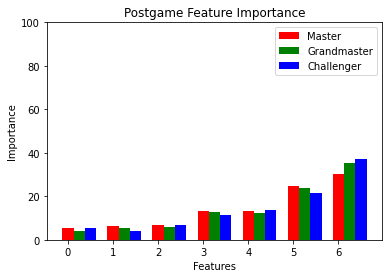

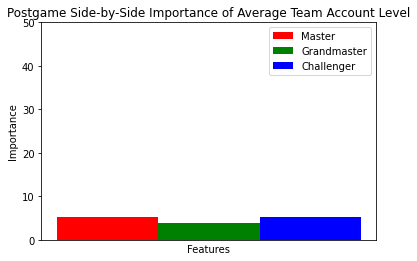

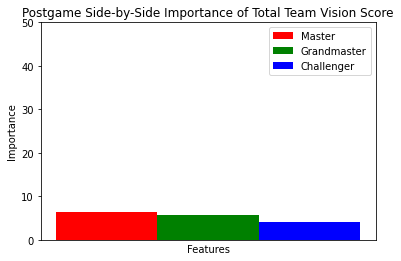

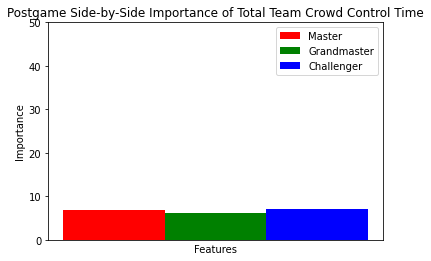

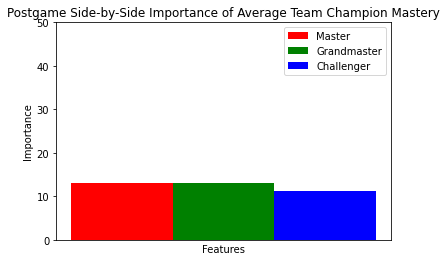

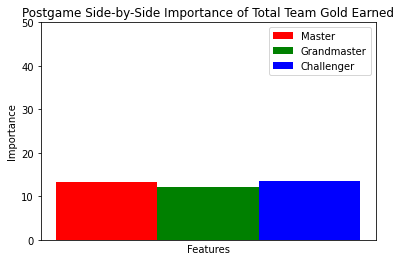

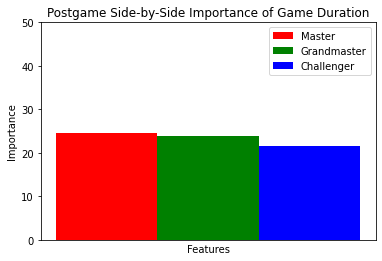

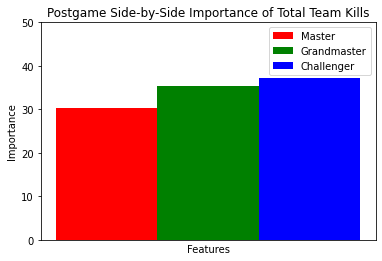

In [334]:
postgameFeatures = challengerData.columns[:len(challengerData.columns) - 1]

postgameFeatures = ["Average Team Account Level", "Total Team Vision Score", "Total Team Crowd Control Time", "Average Team Champion Mastery",
"Total Team Gold Earned", "Game Duration", "Total Team Kills"]

ranks = ["Master", "Grandmaster", "Challenger"]

masterImp = [5.277408, 6.406849, 6.890230, 13.135445, 13.320580, 24.579913, 30.389576] # level, vision, cctime, mastery, gold, gamedur, kills
gmImp = [3.964566, 5.638101, 6.075774, 13.010113, 12.103502, 23.920335, 35.287609] # level, vision, cctime, gold, mastery, gamedur, kills Fixed
challImp = [5.261508, 4.180141, 7.019170, 11.230696, 13.541553, 21.602689, 37.164242] # vision, level, cctime, mastery, gold, gamedur, kills Fixed


N = 7
ind = np.arange(N)
width=0.25

plt.xlabel("Features")
plt.ylabel('Importance')
plt.title("Postgame Feature Importance")

bar1 = plt.bar(ind, masterImp, width, color="r")
bar2 = plt.bar(ind + width, gmImp, width, color="g")
bar3 = plt.bar(ind + width + width, challImp, width, color="b")

# plt.xticks(ind+width,postgameFeatures)
plt.ylim(top=100)
plt.legend((bar1, bar2, bar3), ranks)
plt.show()

for i in ind:
    plt.title("Postgame Side-by-Side Importance of " + postgameFeatures[i])
    plt.xlabel("Features")
    plt.ylabel('Importance')

    bar1 = plt.bar(1, masterImp[i], width, color="r")
    bar2 = plt.bar(1 + width, gmImp[i], width, color="g")
    bar3 = plt.bar(1 + width + width, challImp[i], width, color="b")

    plt.xticks(ticks=[])
    plt.ylim(top=50)
    plt.legend((bar1, bar2, bar3), ranks)
    plt.show()
